# Introduction & Outline

To start, there is two NLP tasks, one being with fake news detection (text classification), and another being text summarization.

For the fake news classification problem, the task is to correctly label a given story as true or false based on training data.  The data for fake news is coming from Huggingface, its fairly clean, although I did fix some cells in Excel to fix a few errors.  I will primarily just be grabbing  statistical information as well as some analytics about the text(s).  I will also look at some of the most commonly used words or phrases to see if that yeilds more meaningful pattern.  Since this is fake news, I would think there are phrases or headlines that could point to being fake or real.  


For the text summarization, the goal is to simply get a consise and accraute summary of a given document.  Some methods that can work for this include text based extraction; which looks for what it considers a key phrase or phrases to return the most important aspects of the document. The general flow of this is: tokenizing sentences, scoring them based on weighted frequencies (what words affect the activation the most), and then setting a threshold for the sentences.  Usually, its based on getting the average weight and setting a number based on that to decide what sentences get summarized, still with me?  Cool, also there is an abstraction apporach, is a little more complex so I'll circle back to it later, but it uses seq2seq encoding.  Knowing that context matters here and this is a more involved process using recurrent neural networks, for now we'll circle back to it later.  For part 1, I'm using a small text document I found online.  Then taking looking at parts of speech (more weighted elements), complexity of the ready (harder the read, the worse the performance), and word frequency.

In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


data\evaluation.csv
data\test.csv
data\train.csv


In [2]:
input_data_path = 'data/'
training_data_file = 'train.csv'
df = pd.read_csv(input_data_path + training_data_file)
df.head()

,id,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization�s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


### Grabbing total size of the training dataset and general stats

In [3]:
print("size of training dataset: " + str(len(df)))
df.describe(include=['object'])

size of training dataset: 24338


,title,text
count,24338,24338
unique,24047,24337
top,no title,"In its 109-year history, only one F.B.I. direc..."
freq,105,2


### Quick tally of the real vs fake stories

Number of real stories: 13239
Number of fake stories: 11099
total stories: 24338


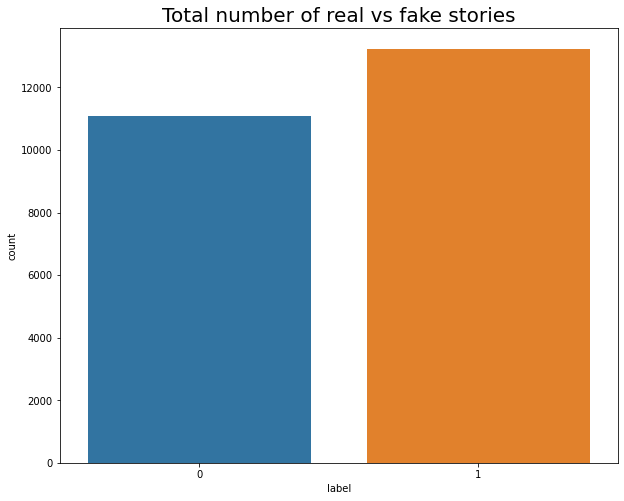

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

trueStories = df.loc[df['label'] == 1]
faketories = df.loc[df['label'] == 0]
print("Number of real stories: " + str(len(trueStories)))
print("Number of fake stories: " + str(len(faketories)))
print("total stories: " + str(len(faketories + trueStories)))

plt.figure(figsize = (10, 8))
ax = sns.countplot(x = df['label'], data = df)
ax.set_title(label = 'Total number of real vs fake stories', fontsize = 20)
plt.show()




# General data analysis
---------------------------------------------------------------------
### length of text(s) and title(s) distribution

In [5]:
df['title_len'] = df['title'].astype(str).apply(len)
df['text_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

array([[<AxesSubplot:title={'center':'title_len'}>,
        <AxesSubplot:title={'center':'text_len'}>],
       [<AxesSubplot:title={'center':'word_count'}>, <AxesSubplot:>]],
      dtype=object)

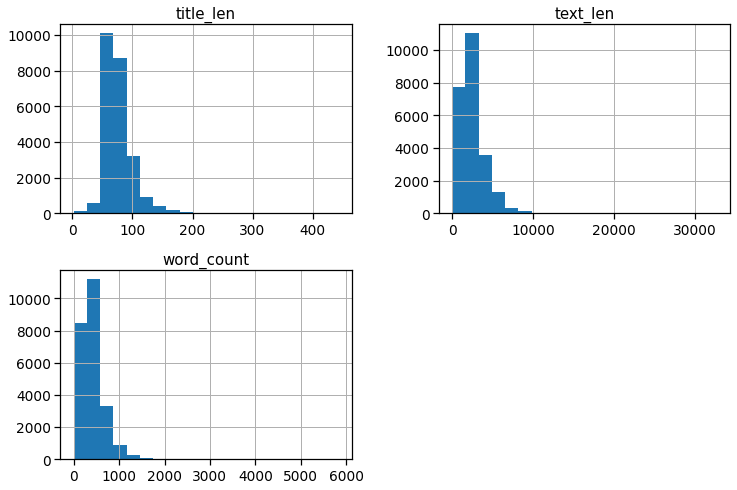

In [15]:
df[["title_len", "text_len", "word_count"]].hist(bins=20, figsize=(12, 8))

# Frequency of words

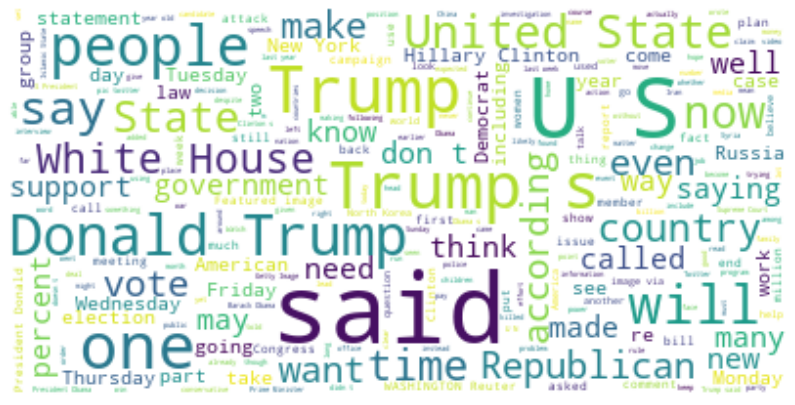

In [7]:
text = " ".join(text for text in df.text)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcl = WordCloud(stopwords = stopwords, background_color='white', max_font_size = 50, max_words = 5000).generate(text)
plt.figure(figsize=(14, 12))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()

## Preprocessing to get "cleaner data" for analysis

In [5]:
import nltk
from collections import Counter
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import re


## text cleansing

#get rid of special characters

def cleantxt(txt):
    txt = txt.str.replace("()", "")
    txt = txt.str.replace('(<a).*(>).*()', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')
    txt = txt.str.replace("~", "")
    txt = txt.str.replace("`", "")
    txt = txt.str.replace("-", "")    
    txt = txt.str.replace("-", "")
    txt = txt.str.replace("_", "")  
    return txtdf['text'] == cleantxt(df['text'])



# convert to lowercase
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# # remove punctuations
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# # remove stopwords
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# df['text'].head()

#---------------------------------------------------------------------------------------------#
## title cleansing
#---------------------------------------------------------------------------------------------#

ttl = " ".join(title for title in df.title)

#get rid of special characters

def cleanTitle(ttl):
    ttl = ttl.str.replace("()", "")
    ttl = ttl.str.replace('(<a).*(>).*()', '')
    ttl = ttl.str.replace('(&amp)', '')
    ttl = ttl.str.replace('(&gt)', '')
    ttl = ttl.str.replace('(&lt)', '')
    ttl = ttl.str.replace('(\xa0)', ' ')
    ttl = ttl.str.replace("~", "")
    ttl = ttl.str.replace("`", "")
    ttl = ttl.str.replace("�", "")    
    ttl = ttl.str.replace("-", "")
    ttl = ttl.str.replace("_", "")  
    return ttldf['title'] == cleanTitle(df['title'])



# convert to lowercase
df['title'] = df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# # remove punctuations
df['title'] = df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))


# df['title'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot:>

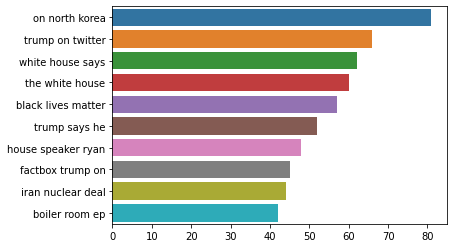

In [6]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# top_tri_grams=get_top_ngram(df['title'],n=6)
# x,y=map(list,zip(*top_tri_grams))
# sns.barplot(x=y,y=x)

top_n_grams=get_top_ngram(df['title'],n=3)
x,y=map(list,zip(*top_n_grams))
sns.barplot(x=y,y=x)



c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


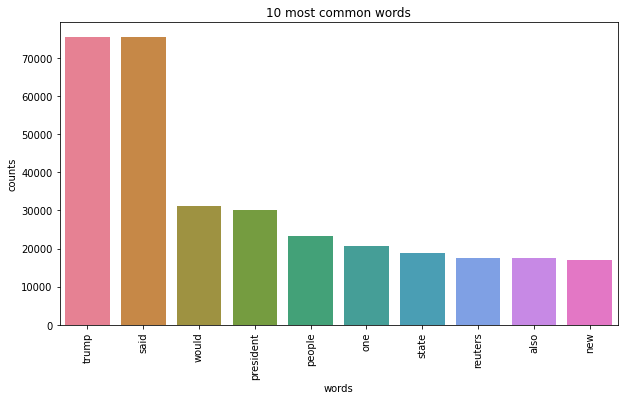

In [7]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.figure(2, figsize=(10, 9/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(df['text'])
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
# Visualise the 10 most common words
plot_10_most_common_words(tf, tf_vectorizer)

# Text Summarization 

Switching over to the text summarization, the dataset is an article I found online, its a small paragraph of text.  However, its best to start small and show the process here; then build up to a larger text, which will be done later.



In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

text = nlp("""Peter and Elizabeth took a taxi to attend the night party in the city. 
While in the party, Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury, 
the doctor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving.
""")


[(x.text,x.label_) for x in text.ents]

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('Peter', 'PERSON'),
 ('Elizabeth', 'PERSON'),
 ('Elizabeth', 'PERSON'),
 ('Peter', 'PERSON'),
 ('Peter', 'PERSON'),
 ('3 days', 'DATE')]

In [10]:
from spacy import displacy
displacy.render(text, style='ent')

### Listing out some text data, via textstat a library that has a range of funvtions to compute the complexity of a peice of text
___________________________________________________________________________________________________________________

In [6]:
import textstat

text = """Peter and Elizabeth took a taxi to attend the night party in the city. 
While in the party, Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury, 
the doctor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving.
"""

print("ease of readability: " + str(textstat.flesch_reading_ease(text)) + " which is Fairly Easy")
print("grade level difficulty: " + str(textstat.dale_chall_readability_score(text)) + " average  for 9th or 10th grade student")
print("there is " + str(textstat.lexicon_count(text, removepunct=True))+ " words in document")
print("there is " + str(textstat.sentence_count(text))+ " sentences in the doucment")


ease of readability: 73.37 which is Fairly Easy
grade level difficulty: 7.58 average  for 9th or 10th grade student
there is 59 words in document
there is 4 sentences in the doucment


### Word frequency

In [21]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

text = """Peter and Elizabeth took a taxi to attend the night party in the city. 
While in the party, Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury, 
the texttor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving.
"""

#get rid of special characters

text = text.replace(".", "")
text = text.replace(",", "")
text = text.replace("-", "")    
text = text.replace("-", "")
text = text.replace(",", "")  

       
# Removing stop words
stop_words = set(stopwords.words("english"))

words = word_tokenize(text)

# Creating dictionary for the word frequency table
frequency_table = {}

for wd in words:
    wd = wd
    if wd in stop_words:
        continue
    if wd in frequency_table:
        frequency_table[wd] += 1
    else:
        frequency_table[wd] = 1


print('word         freq')
print('-----------------')
for word, freq in frequency_table.items():
    print('{:<12} {:<25}'.format(word, freq))



word         freq
-----------------
Peter        3                        
Elizabeth    2                        
took         1                        
taxi         1                        
attend       1                        
night        1                        
party        2                        
city         1                        
While        1                        
collapsed    1                        
rushed       1                        
hospital     2                        
Since        1                        
diagnosed    1                        
brain        1                        
injury       1                        
texttor      1                        
told         1                        
stay         1                        
besides      1                        
gets         1                        
well         1                        
Therefore    1                        
stayed       1                        
3            1              

## Summary

Assessing the complexity, getting the parts of speech, and building a frequency table help get us a better picture of what might be key for generating a summary from.  going further, I would like to do some topic modeling and calculating weighted frequencies, getting an average, and tweaking thresholds to start a baseline model to work from.